In [1]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from data_utils import *

In [2]:
data_dir = '../data/'

# load the data
grf_data = np.load(data_dir + 'grf.npy', mmap_mode='r')
muscle_data = np.load(data_dir + 'muscle.npy', mmap_mode='r')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [3]:
data = np.concatenate((grf_data, muscle_data), axis=2)
# print(data.shape)

np.random.seed(42)
np.random.shuffle(data)

In [4]:
num_samples = data.shape[0]
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)

print(f"Number of samples: {num_samples}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

Number of samples: 13388
Train size: 10710
Validation size: 1338


In [5]:
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)


In [6]:
X_train, y_train = train_data[:, :, :3], train_data[:, :, 3:]
X_val, y_val = val_data[:, :, :3], val_data[:, :, 3:]
X_test, y_test = test_data[:, :, :3], test_data[:, :, 3:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

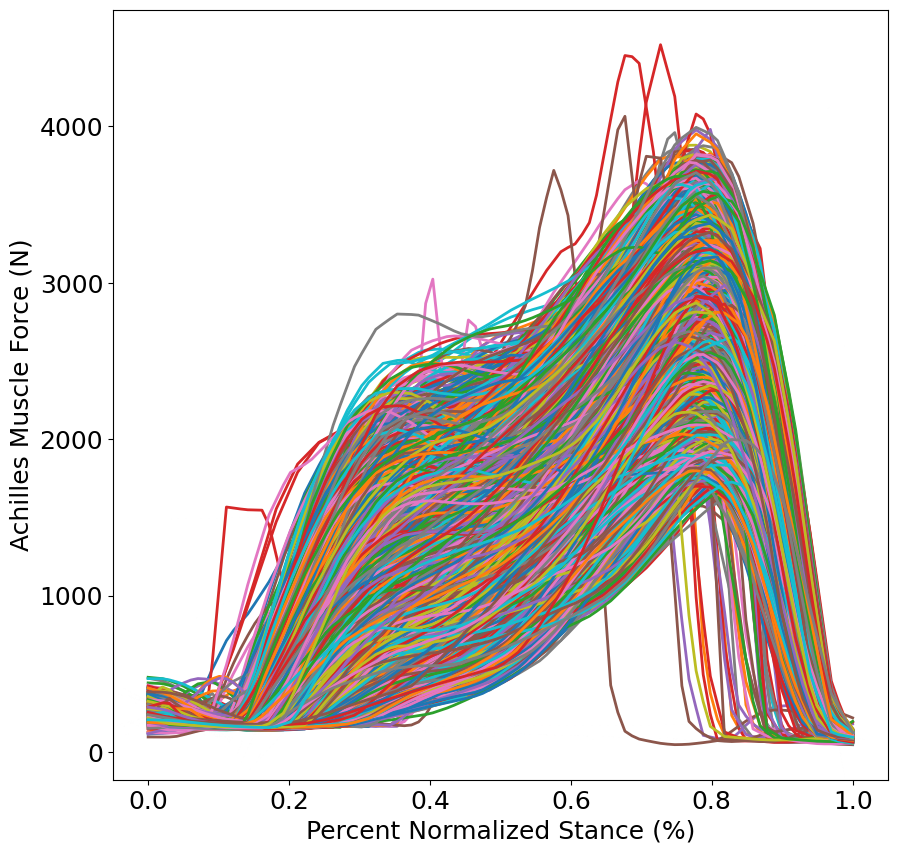

In [7]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance (%)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        
        self.input_embedding = nn.Linear(input_dim, d_model)
        # self.positional_encoding = nn.Parameter(self._generate_positional_encoding(d_model, max_len=100))
        self.register_buffer("positional_encoding", self._generate_positional_encoding(d_model, max_len=100))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        seq_len = x.size(1)
        x = self.input_embedding(x)  # (batch_size, sequence_length, d_model)
        
        x = x + self.positional_encoding[:, :seq_len, :].to(x.device)  # Add positional encoding
        
        x = self.transformer_encoder(x)  # (sequence_length, batch_size, d_model)
        
        output = self.output_layer(x)  # (batch_size, sequence_length, output_dim)
        
        return output

    @staticmethod
    def _generate_positional_encoding(d_model, max_len=100):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log1p(torch.tensor(10000.0)) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # Add batch dimension

In [9]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# # create dataloaders from datasets
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
def train_eval(train_dataset, val_dataset, d_model, num_heads, num_encoder_layers, dim_feedforward,
               dropout_rate, learning_rate, batch_size, regularization, num_epochs=50):
    # prepare DataLoader with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # initialize the model
    model = TransformerModel(input_dim=3,
                             output_dim=9, 
                             d_model=d_model, 
                             nhead=num_heads, 
                             num_encoder_layers=num_encoder_layers, 
                             dim_feedforward=dim_feedforward, 
                             dropout=dropout_rate)
    
    # move the model to the device
    model.to(device)    
    
    # initialize the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
    
    # early stopping setup
    patience = 10
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # training loop
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()
        
        # initialize training loss
        train_loss = 0.0

        # iterate over the training data
        for X_batch, y_batch in train_loader:
            # zero the gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(X_batch)
            
            # calculate the loss
            loss = criterion(outputs, y_batch)
            
            # backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # update training loss
            train_loss += loss.item() * X_batch.size(0)
        
        # average training loss over all samples
        train_loss /= len(train_loader.dataset)
        
        # validation step
        # set the model to evaluation mode
        model.eval()
        
        # initialize validation loss
        val_loss = 0.0
        
        # turn off gradients for validation
        with torch.no_grad():
            # iterate over the validation data
            for X_batch, y_batch in val_loader:
                # forward pass
                outputs = model(X_batch)
                
                # calculate the loss
                loss = criterion(outputs, y_batch)
                
                # update validation loss
                val_loss += loss.item() * X_batch.size(0)

        # average validation loss over all samples
        val_loss /= len(val_loader.dataset)
        
        # # print progress
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # early stopping check
        if val_loss < best_val_loss:
            # save best validation loss
            best_val_loss = val_loss
            
            # reset epochs without improvement
            epochs_without_improvement = 0
            
            # save the best model
            # torch.save(model.state_dict(), 'best_model.pth')
            best_model_state_dict = model.state_dict()
        else:
            # increment epochs without improvement
            epochs_without_improvement += 1

        # break if patience limit is reached
        if epochs_without_improvement >= patience:
            break

    # load the best model's state for this set of hyperparameters
    # model.load_state_dict(torch.load('best_model.pth'))
    model.load_state_dict(best_model_state_dict)
    
    # return the best validation loss
    return best_val_loss, model

In [12]:
import optuna

def objective(trial):
    # Sample hyperparameters
    d_model = trial.suggest_categorical('d_model', [32, 64, 128])
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
    num_encoder_layers = trial.suggest_categorical('num_encoder_layers', [2, 4, 6])
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, log=False)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)

    # Train and evaluate with these hyperparameters
    val_loss, _ = train_eval(train_dataset, val_dataset, d_model, num_heads, num_encoder_layers, dim_feedforward, 
                   dropout_rate, learning_rate, batch_size, regularization, num_epochs=500)
    
    # Return the validation loss (minimize this value)
    return val_loss

In [13]:
# Define the study
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Start the optimization
study.optimize(objective, n_trials=100)  # Run 100 trials

[I 2024-11-26 16:44:45,728] A new study created in memory with name: no-name-f4f828c3-40a7-40df-bbc2-9c108c55eeaf
[I 2024-11-26 16:48:50,422] Trial 0 finished with value: 93789.02741965621 and parameters: {'d_model': 128, 'num_heads': 8, 'num_encoder_layers': 4, 'dim_feedforward': 256, 'dropout_rate': 0.04117020483663619, 'learning_rate': 0.0017044731999422442, 'batch_size': 128, 'regularization': 0.0001613989100456791}. Best is trial 0 with value: 93789.02741965621.
[I 2024-11-26 16:58:30,359] Trial 1 finished with value: 3396.4953463658444 and parameters: {'d_model': 32, 'num_heads': 8, 'num_encoder_layers': 6, 'dim_feedforward': 64, 'dropout_rate': 0.4305776707147756, 'learning_rate': 0.0009411992780526087, 'batch_size': 128, 'regularization': 0.0010826603742184343}. Best is trial 1 with value: 3396.4953463658444.
[I 2024-11-26 16:59:25,971] Trial 2 finished with value: 85057.21915872571 and parameters: {'d_model': 32, 'num_heads': 2, 'num_encoder_layers': 6, 'dim_feedforward': 128,

In [14]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'d_model': 32, 'num_heads': 8, 'num_encoder_layers': 6, 'dim_feedforward': 256, 'dropout_rate': 0.012122943820592716, 'learning_rate': 0.0009945999112164741, 'batch_size': 128, 'regularization': 1.0244940906139135e-05}


In [15]:
# Train the final model with the best hyperparameters
final_val_loss, best_model = train_eval(train_dataset, val_dataset,
                                        d_model=best_params['d_model'],
                                        num_heads=best_params['num_heads'],
                                        num_encoder_layers=best_params['num_encoder_layers'],
                                        dim_feedforward=best_params['dim_feedforward'],
                                        dropout_rate=best_params['dropout_rate'],
                                        learning_rate=best_params['learning_rate'],
                                        batch_size=best_params['batch_size'],
                                        regularization=best_params['regularization'],
                                        num_epochs=1000)

In [17]:
torch.save(best_model.state_dict(), '..\models\\transformer.pth')

In [18]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
best_model.eval()

# initialize test loss
test_loss = 0

criterion = nn.MSELoss()

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = best_model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 890.1572


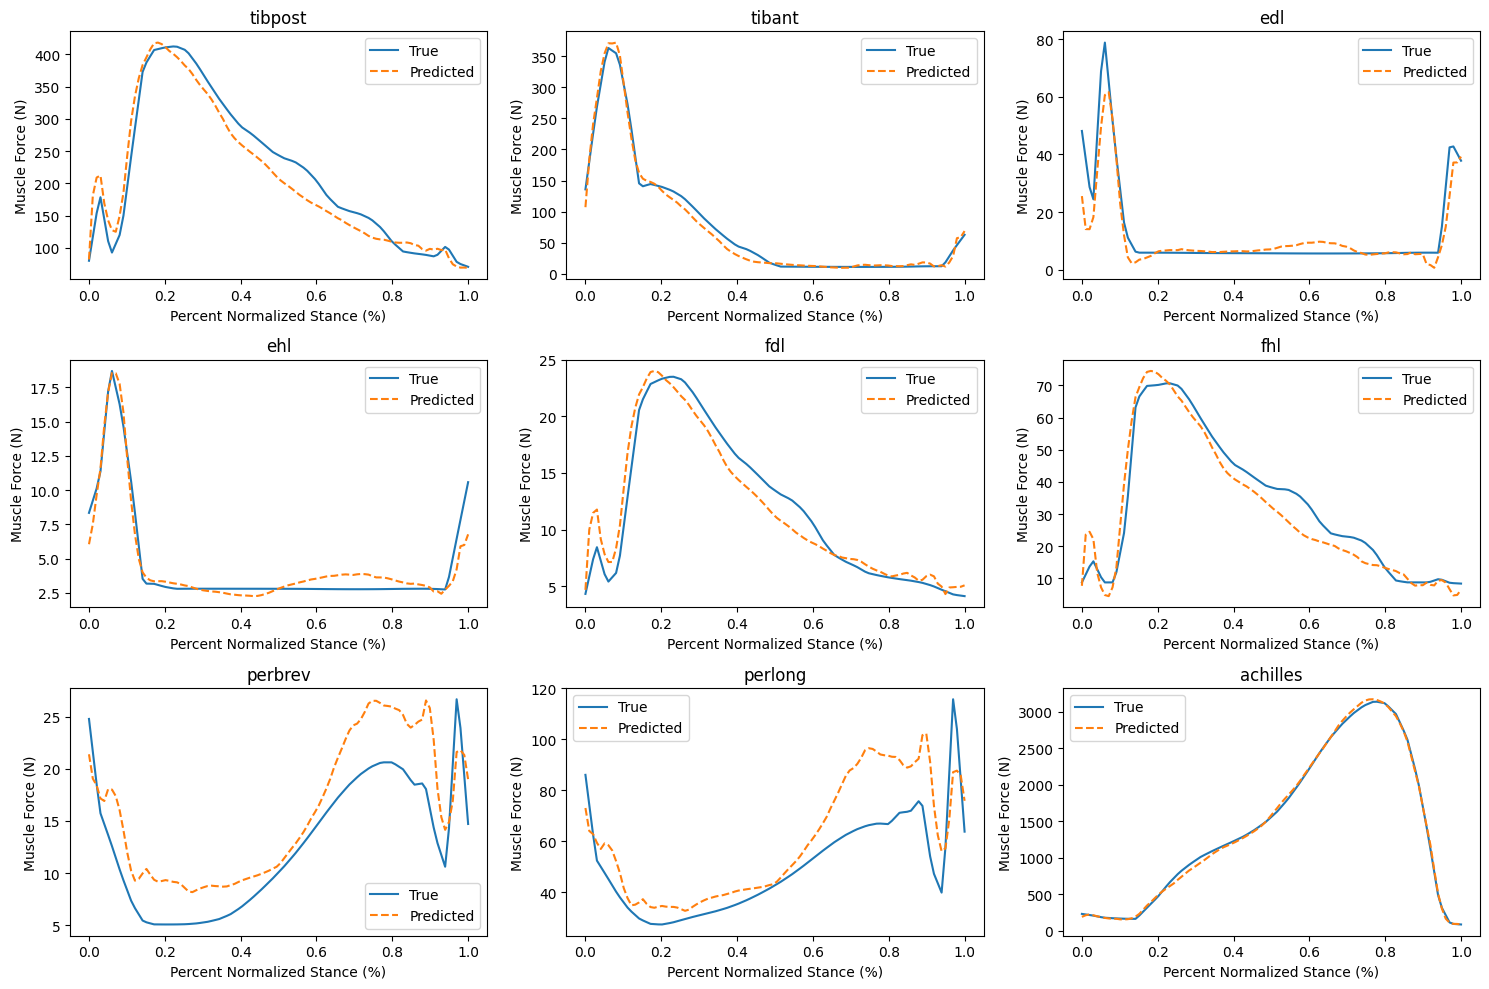

In [19]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()